In [1]:
import math
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from model import Net
from preprocessor import CorpusPreprocessor
from dataset import CorpusDataset

In [2]:
DATA_FILE = 'corpus.pt'
MODEL_FILE = 'checkpoint.pt'
DEVICE = 'cuda:0'

cp = CorpusPreprocessor()
cp.load(DATA_FILE)
_, dataset = CorpusDataset.split(cp, 0.8)

net = Net(len(cp.alphabet), cp.max_sentence_length, cp.max_word_length)
net.load_state_dict(torch.load(MODEL_FILE, map_location=DEVICE))
net.to(DEVICE)
we = net.we

Obliczmy embeddingi dla wszystkich słów:

In [3]:
embs = dict()
for w in cp.words:
    with torch.no_grad():
        t = dataset.word2tensor(w).to(DEVICE).unsqueeze(0)
        embs[w] = we(t).squeeze(0).cpu()

## Wizualizacja

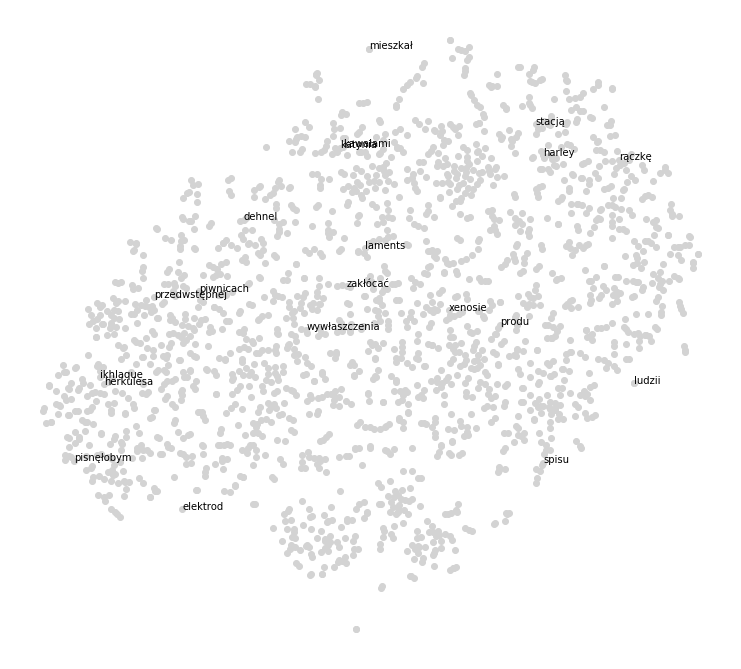

In [4]:
mywords = random.sample(cp.words, 20)
tsne_words = mywords + random.sample(cp.words, 2000)
tsne_embs = torch.stack(tuple(embs[w] for w in tsne_words)).numpy()
tsne = TSNE(perplexity=15, n_components=2).fit_transform(tsne_embs)

plt.figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9, wspace=0.0, hspace=0.0)

xs = list(tsne[:, 0])
ys = list(tsne[:, 1])
plt.scatter(xs, ys, c='lightgrey')
for x, y, w in zip(xs, ys, tsne_words):
    if w in mywords:
        ax.annotate(w, (x, y))

## Podobne słowa
Znajdźmy słowa najbardziej podobne do wybranych (najbliższe w sensie odległości między wektorami)

In [5]:
for mw in mywords:
    print(mw)
    dists = []
    for w in cp.words:
        if w == mw:
            continue
        dist = torch.sqrt(torch.sum((embs[mw] - embs[w]) ** 2)).item()
        dists.append((w, dist))
    dists = sorted(dists, key=lambda x: x[1])
    for w, d in dists[:10]:
        print(f'  {w:<15} {d}')

zakłócać
  zakłócają       1.0203067064285278
  kobiecymi       1.08059823513031
  zakłóciły       1.1358169317245483
  paletowe        1.1462677717208862
  etiologii       1.1537268161773682
  malowniczy      1.1664891242980957
  nauczyło        1.1734724044799805
  pilotażu        1.1835033893585205
  tematyki        1.1877385377883911
  całodniowych    1.1898813247680664
kawałami
  słucham         1.0556105375289917
  kanałami        1.1693994998931885
  słuchamy        1.273029088973999
  remisami        1.350914478302002
  musicali        1.3878355026245117
  bazarami        1.4166263341903687
  blachami        1.485390543937683
  optymizm        1.4887733459472656
  musical         1.5105842351913452
  krzyżami        1.5651742219924927
przedwstępnej
  przedstawiać    0.9887151122093201
  przywiezione    1.076083779335022
  przedstawili    1.0893449783325195
  środowiskowej   1.1148617267608643
  przedsiębiorstwem 1.1279984712600708
  przekonań       1.1282477378845215
  rozrasta

## Relacje semantyczne

In [12]:
testpairs = [
    ('warszawa', 'polska', 'paryż', 'francja'),
    ('niemcy', 'berlin', 'rosja', 'moskwa'),
    ('stół', 'stołu', 'dom', 'domu'),
    ('król', 'mężczyzna', 'królowa', 'kobieta'),
    ('tata', 'mężczyzna', 'mama', 'kobieta'),
    ('on', 'mężczyzna', 'ona', 'kobieta'),
    ('ciepło', 'lato', 'zimno', 'zima'),
    ('ciemno', 'noc', 'jasno', 'dzień'),
    ('samochód', 'koła', 'samolot', 'skrzydła'),
    ('pis', 'kaczyński', 'po', 'tusk'),
    ('samochód', 'samochodem', 'rower', 'rowerem'),
    ('ciasto', 'ciasta', 'kobieta', 'kobiety'),
    ('pies', 'piesek', 'kot', 'kotek'),
    ('ryba', 'jezioro', 'ptak', 'drzewo'),
]

dists = []

for pair in testpairs:
    dist = torch.sqrt(torch.sum(((embs[pair[0]] - embs[pair[1]]) - (embs[pair[2]] - embs[pair[3]])) ** 2)).item()
    dists.append((pair, dist))

for pair, dist in sorted(dists, key=lambda p: p[1]):
    print(f'W({pair[0]:^10}) - W({pair[1]:^10}) ≃ W({pair[2]:^10}) - W({pair[3]:^10}) : {dist}')

W(  ciasto  ) - W(  ciasta  ) ≃ W( kobieta  ) - W( kobiety  ) : 3.300229549407959
W(   pies   ) - W(  piesek  ) ≃ W(   kot    ) - W(  kotek   ) : 4.548885345458984
W(   stół   ) - W(  stołu   ) ≃ W(   dom    ) - W(   domu   ) : 4.8831915855407715
W( samochód ) - W(samochodem) ≃ W(  rower   ) - W( rowerem  ) : 5.0700507164001465
W(    on    ) - W(mężczyzna ) ≃ W(   ona    ) - W( kobieta  ) : 6.4588212966918945
W( samochód ) - W(   koła   ) ≃ W( samolot  ) - W( skrzydła ) : 6.573529243469238
W(   tata   ) - W(mężczyzna ) ≃ W(   mama   ) - W( kobieta  ) : 6.6655988693237305
W(   ryba   ) - W( jezioro  ) ≃ W(   ptak   ) - W(  drzewo  ) : 6.678488254547119
W(  niemcy  ) - W(  berlin  ) ≃ W(  rosja   ) - W(  moskwa  ) : 6.685856819152832
W( warszawa ) - W(  polska  ) ≃ W(  paryż   ) - W( francja  ) : 6.8702006340026855
W(   król   ) - W(mężczyzna ) ≃ W( królowa  ) - W( kobieta  ) : 7.0598273277282715
W(  ciemno  ) - W(   noc    ) ≃ W(  jasno   ) - W(  dzień   ) : 7.141095161437988
W(  ciepło